# 0 Setup

In [1]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

In [29]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [30]:
# Import helper functions
from utils import data_download
from data_setup import create_dataloaders

# 1 Get Data

In [31]:
image_path = data_download(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data/pizza_steak_sushi directory exists, skipping download.


PosixPath('data/pizza_steak_sushi')

In [32]:
train_dir = image_path / "train"
test_dir = image_path / "test"

# 2 Create Datasets and Data Loaders

In [33]:
# create manual transforms:
IMG_SIZE = 224
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [34]:
BATCH_SIZE = 32 
train_dataloader, test_dataloader , class_names = create_dataloaders(
                                                    train_dir,
                                                    test_dir, 
                                                    manual_transforms, 
                                                    BATCH_SIZE
                                                )

In [35]:
image_batch, label_batch = next(iter(train_dataloader))
image, label = image_batch[0], label_batch[0]

print(image.shape, label)

torch.Size([3, 224, 224]) tensor(0)


(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

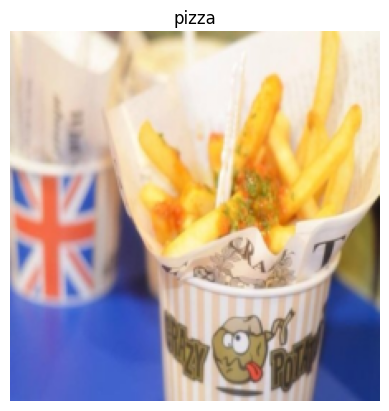

In [36]:
# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False)

# 3 Model Archtiecture

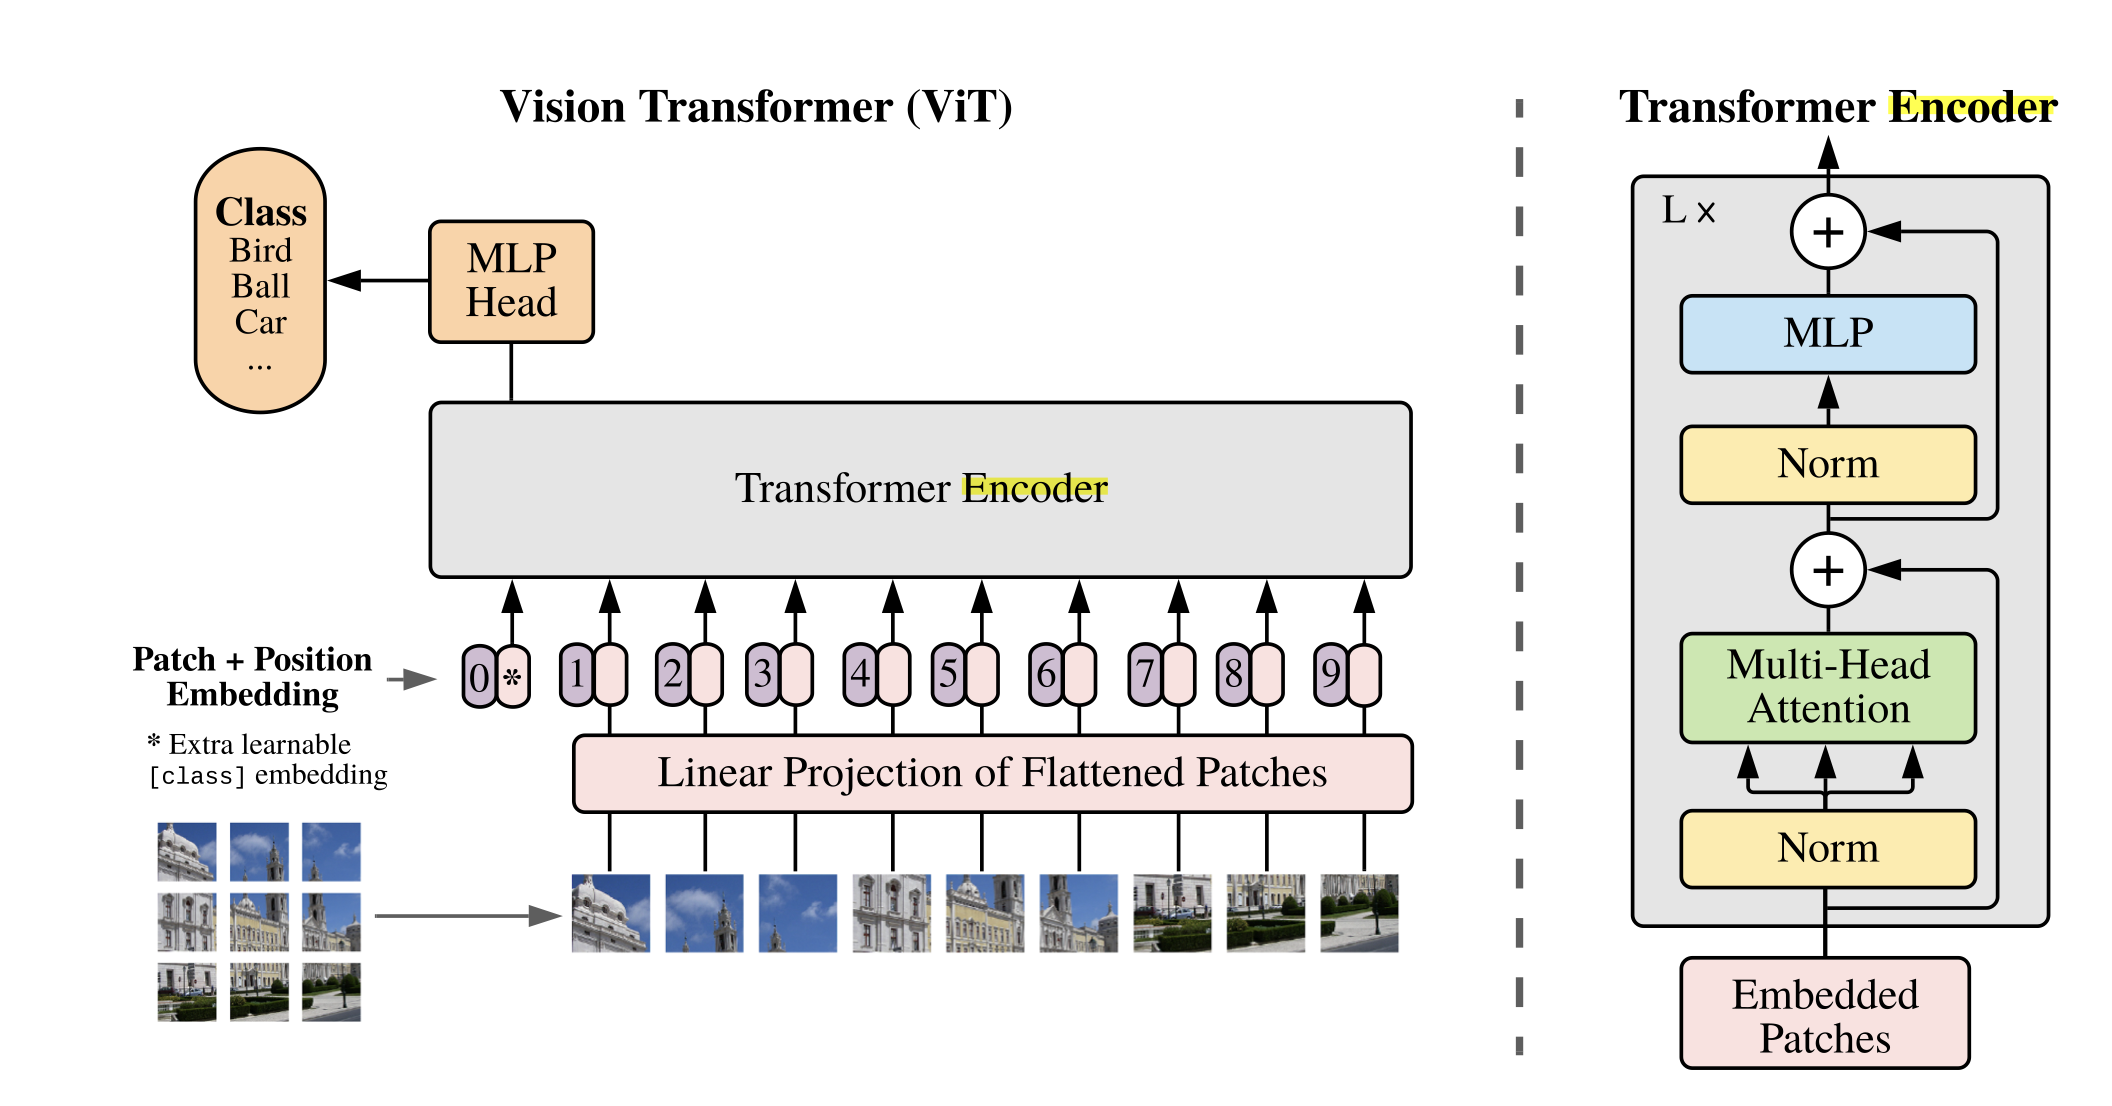

## Equations: 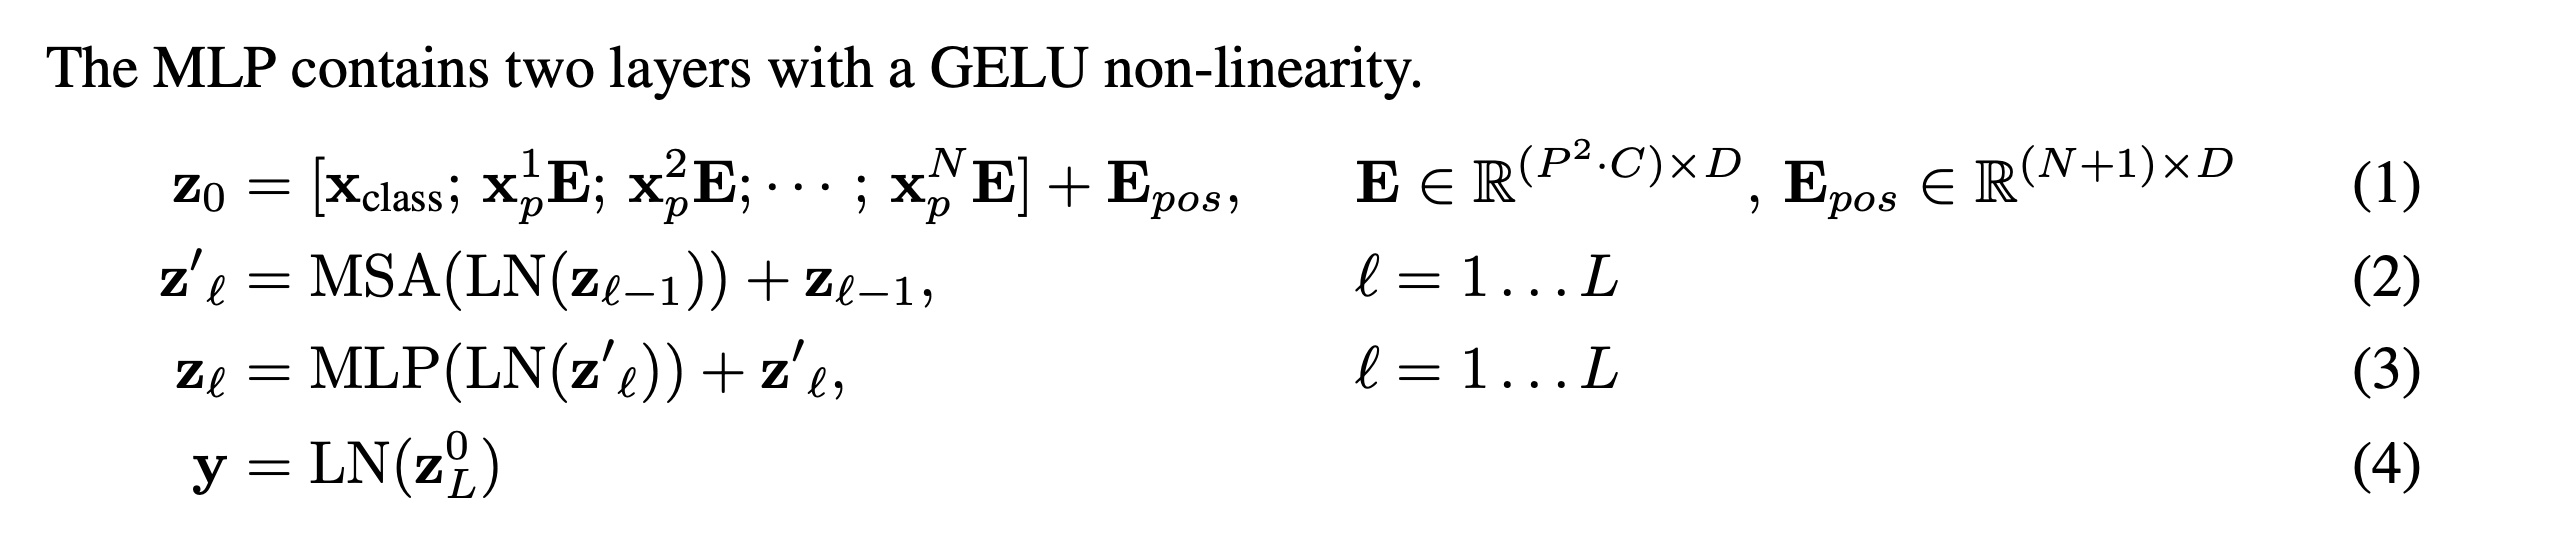

# 3.1 Embedding Patches (Z0)

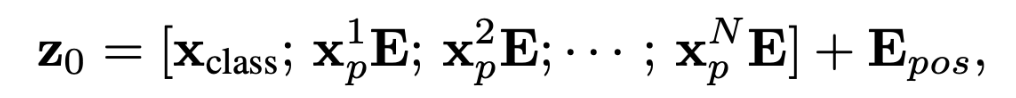

- Create patches (X_class)
- Concat class to patches 
- Add positional embedding (E_pos)

## 3.1.1 Patching the image

In [37]:
# Vit-base model uses a aptch size of 16

# Create example values
height = 224 # H ("The training resolution is 224.")
width = 224 # W
color_channels = 3 # C
patch_size = 16 # P

# Calculate N (number of patches)
number_of_patches = int((height * width) / patch_size**2)
print(f"Number of patches (N) with image height (H={height}), width (W={width}) and patch size (P={patch_size}): {number_of_patches}")

Number of patches (N) with image height (H=224), width (W=224) and patch size (P=16): 196


In [38]:
# Input shape (this is the size of a single image)
embedding_layer_input_shape = (height, width, color_channels)

# Output shape
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 2D image flattened into patches): {embedding_layer_output_shape}")

Input shape (single 2D image): (224, 224, 3)
Output shape (single 2D image flattened into patches): (196, 768)


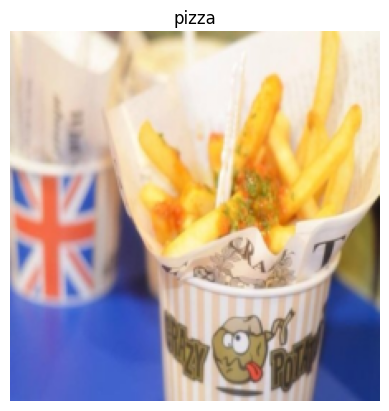

In [39]:
# View single image
plt.imshow(image.permute(1, 2, 0)) # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False);

Number of patches per row ; 14.0
Number of patches per column: 14.0
Total patches: 196.0
patch size: 16 pixels * 16 pixels


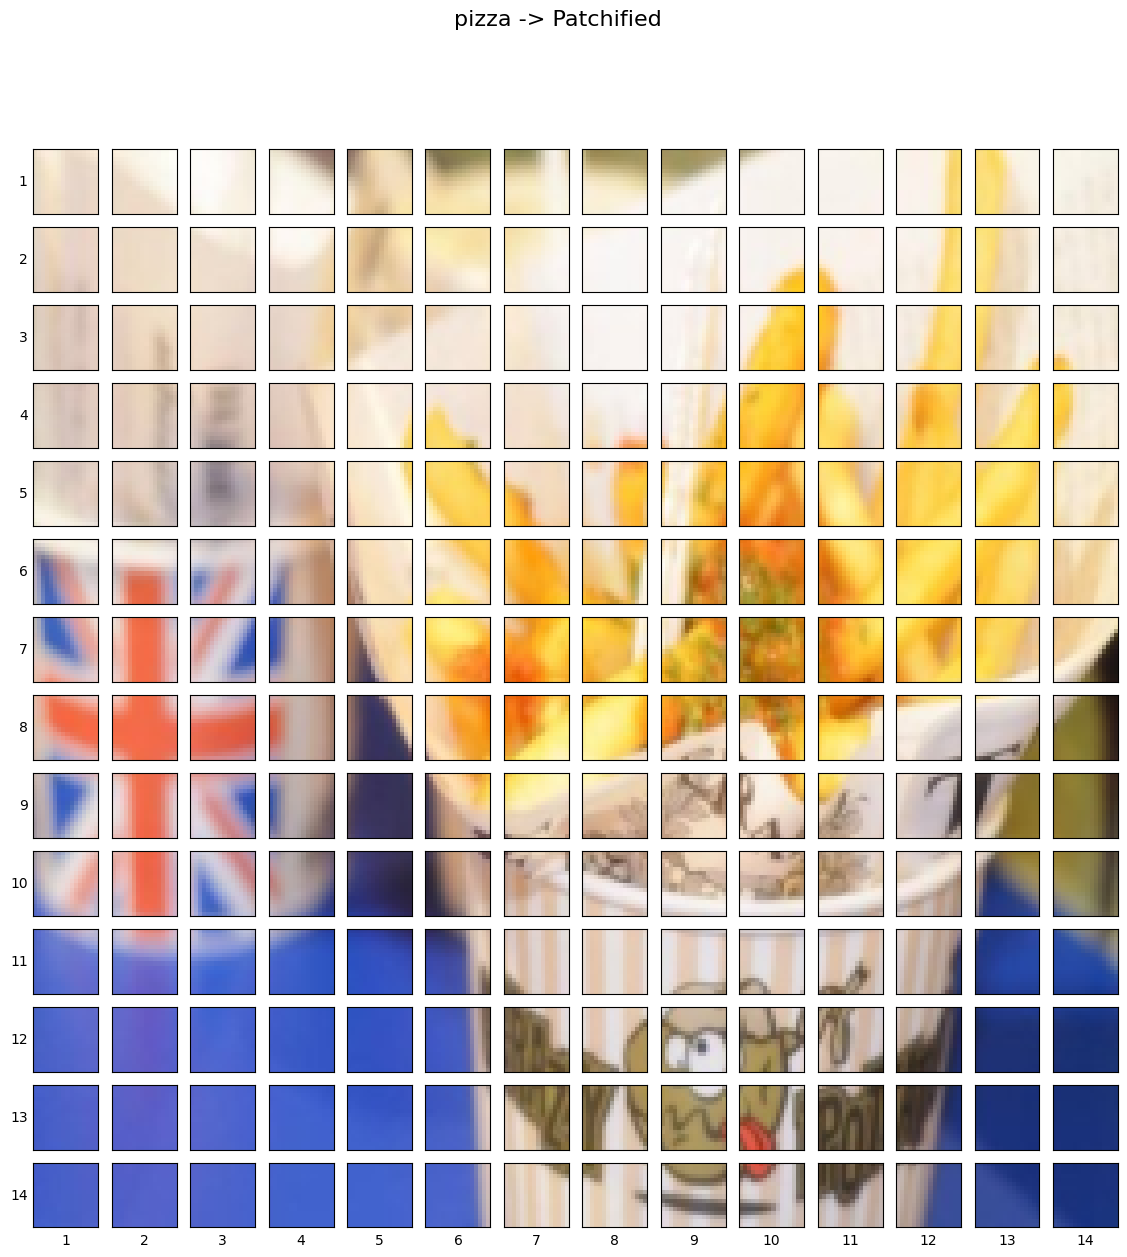

In [40]:
# convert single image to patches:

img_size = 224
patch_size = 16
num_patches = img_size / patch_size

assert img_size % patch_size == 0, "Image size must be divisible by patch size"

# Rearrange dims to make compatible with matplotlib - (color_channels, height, width) -> (height, width, color_channels)
image_permuted = image.permute(1, 2, 0)  

print(f"Number of patches per row ; {img_size / patch_size}")
print(f"Number of patches per column: {img_size / patch_size}")
print(f"Total patches: {num_patches * num_patches}")
print(f"patch size: {patch_size} pixels * {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=img_size // patch_size, # need int not float
                        ncols=img_size // patch_size,
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

for i, patch_height in enumerate(range(0, img_size, patch_size)):
    for j , patch_width in enumerate(range(0, img_size, patch_size)):

        axs[i,j].imshow(image_permuted[patch_height:patch_height+patch_size, # iterate through height
                                        patch_width:patch_width+patch_size, # iterate through width
                                        :]) # all the color channels. 

        axs[i, j].set_ylabel(i+1,rotation="horizontal",
                                horizontalalignment="right",
                                verticalalignment="center")
        axs[i, j].set_xlabel(j+1)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].label_outer()

# Set a super title
fig.suptitle(f"{class_names[label]} -> Patchified", fontsize=16)
plt.show()
                            

### Creating pathes with Conv2D. 
- Instead of iterating and creating patches manually, we can use the torch Conv2D layer to create patches. 
- Set the kernel_size and stride equivalent to the patch size. 
- Hybrid Architecture. As an alternative to raw image patches, the input sequence can be formed from feature maps of a CNN.


### We can recreate these with:

- torch.nn.Conv2d() for turning our image into patches of CNN feature maps.
- torch.nn.Flatten() for flattening the spatial dimensions of the feature map.

In [41]:
from torch import nn 

patch_size = 16
conv2d = nn.Conv2d(in_channels = 3,
                    out_channels = 768,
                    kernel_size = patch_size,
                    stride = patch_size,
                    padding = 0)

'''
Why 768?

for an image of 224 with 3 channels, when converted to patches of size: 16x16
There are 196 patches made. Each patch with have patch_size * patch_size * 3 (channels) pixels. 
Hence we consider output embedding dimension to be ---> 768 [patch_size * patch_size * 3 (channels)] OR [16*16*3]
'''


'\nWhy 768?\n\nfor an image of 224 with 3 channels, when converted to patches of size: 16x16\nThere are 196 patches made. Each patch with have patch_size * patch_size * 3 (channels) pixels. \nHence we consider output embedding dimension to be ---> 768 [patch_size * patch_size * 3 (channels)] OR [16*16*3]\n'

torch.Size([1, 768, 14, 14])


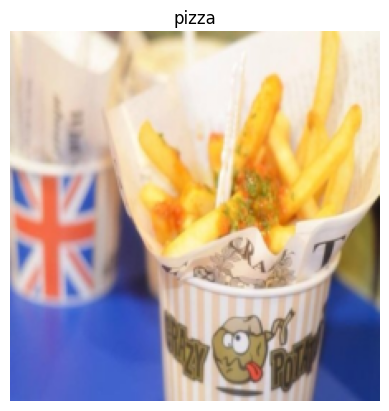

In [42]:
# View single image
plt.imshow(image.permute(1, 2, 0)) # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False);

# Pass the image through the convolutional layer
image_out_of_conv = conv2d(image.unsqueeze(0)) # add a single batch dimension (height, width, color_channels) -> (batch, height, width, color_channels)
print(image_out_of_conv.shape)

# [batch_size, embedding_dim, feature_map_height, feature_map_width]

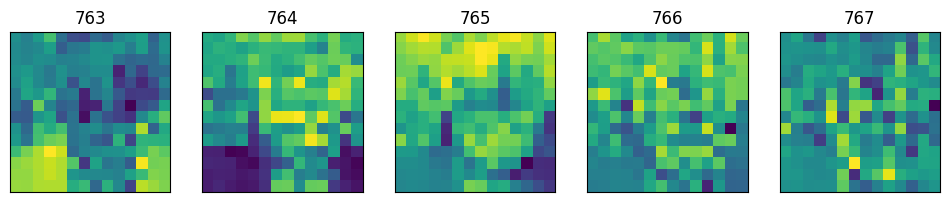

In [43]:
# Printing random feature maps of patches:

import random
random_indexes = random.sample(range(0,758), k=5)
fig, axs = plt.subplots(nrows=1, ncols= 5, figsize = (12,12))

for i, idx in enumerate([763, 764, 765, 766, 767]):
    img_conv_feature_map = image_out_of_conv[:, idx, :, :]
    axs[i].imshow(img_conv_feature_map.squeeze().detach().numpy())
    axs[i].title.set_text(idx)
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[]);

In [44]:
# Create flatten layer
flatten = nn.Flatten(start_dim=2, # flatten feature_map_height (dimension 2)
                     end_dim=3) # flatten feature_map_width (dimension 3)

'''
of the 4 dimensions, [batch_size, embedding_dim, feature_map_height, feature_map_width]
We only want to flatten the height and widht (spatial dimenesions) of the feature map. 
'''

'\nof the 4 dimensions, [batch_size, embedding_dim, feature_map_height, feature_map_width]\nWe only want to flatten the height and widht (spatial dimenesions) of the feature map. \n'

Original image shape: torch.Size([3, 224, 224])
Image feature map shape: torch.Size([1, 768, 14, 14])
Flattened image feature map shape: torch.Size([1, 768, 196])


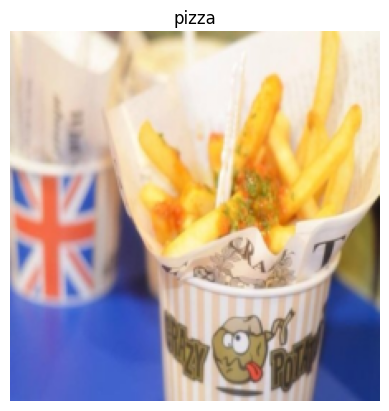

In [45]:
# 1. View single image
plt.imshow(image.permute(1, 2, 0)) # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False);
print(f"Original image shape: {image.shape}")

# 2. Turn image into feature maps
image_out_of_conv = conv2d(image.unsqueeze(0)) # add batch dimension to avoid shape errors
print(f"Image feature map shape: {image_out_of_conv.shape}")

# 3. Flatten the feature maps
image_out_of_conv_flattened = flatten(image_out_of_conv)
print(f"Flattened image feature map shape: {image_out_of_conv_flattened.shape}")


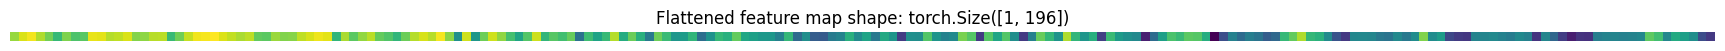

In [46]:
#4. permute to deisred output dimensions: (1,768,196) --->(1, 196, 768))
image_out_of_conv_flattened_reshaped = image_out_of_conv_flattened.permute(0, 2, 1) # [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]


single_flattened_feature_map = image_out_of_conv_flattened_reshaped[:, :, 0] # index: (batch_size, number_of_patches, embedding_dimension)

# Plot the reshaped image: 
plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False);

In [47]:
# import patch embedding class and create flattened patches
from ViT import PatchEmbedding
from utils import set_seeds

set_seeds()

# Create an instance of patch embedding layer
patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)

# Pass a single image through
print(f"Input image shape: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0)) # add an extra batch dimension on the 0th index, otherwise will error
print(f"Output patch embedding shape: {patch_embedded_image.shape}")

Input image shape: torch.Size([1, 3, 224, 224])
Output patch embedding shape: torch.Size([1, 196, 768])


In [48]:
# Create random input sizes
random_input_image = (1, 3, 224, 224)
random_input_image_error = (1, 3, 250, 250) # will error because image size is incompatible with patch_size

# Get a summary of the input and outputs of PatchEmbedding 
summary(PatchEmbedding(),
        input_size=random_input_image, # OR swap and check for random_input_image_error
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
PatchEmbedding (PatchEmbedding)          [1, 3, 224, 224]     [1, 196, 768]        --                   True
├─Conv2d (patcher)                       [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
├─Flatten (flatten)                      [1, 768, 14, 14]     [1, 768, 196]        --                   --
Total params: 590,592
Trainable params: 590,592
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 115.76
Input size (MB): 0.60
Forward/backward pass size (MB): 1.20
Params size (MB): 2.36
Estimated Total Size (MB): 4.17

## 3.1.2 Adding class label to patches 

In [49]:
# View the patch embedding and patch embedding shape
print(patch_embedded_image)
print(f"Patch embedding shape: {patch_embedded_image.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[-0.9367,  0.2304, -0.2421,  ...,  0.6643, -0.4334,  0.3613],
         [-1.0070,  0.2692, -0.2000,  ...,  0.7158, -0.4675,  0.3300],
         [-1.0018,  0.2214, -0.2645,  ...,  0.7654, -0.4640,  0.3747],
         ...,
         [-0.4357,  0.0886, -0.2266,  ...,  0.2279, -0.1188,  0.4053],
         [-0.2672,  0.0792, -0.1765,  ...,  0.2662, -0.0755,  0.1098],
         [-0.2222,  0.0906, -0.1315,  ...,  0.2308, -0.0616,  0.0505]]],
       grad_fn=<PermuteBackward0>)
Patch embedding shape: torch.Size([1, 196, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [50]:
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]

class_token = nn.Parameter(torch.ones(batch_size, 1 , embedding_dimension), requires_grad=True)


# Add the class token embedding to the front of the patch embedding
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image),
                                                      dim=1) # concat on first dimension (0th dimension is the batch)
# Print the sequence of patch embeddings with the prepended class token embedding
print(patch_embedded_image_with_class_embedding)
print(f"Sequence of patch embeddings with class token prepended shape: {patch_embedded_image_with_class_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.9367,  0.2304, -0.2421,  ...,  0.6643, -0.4334,  0.3613],
         [-1.0070,  0.2692, -0.2000,  ...,  0.7158, -0.4675,  0.3300],
         ...,
         [-0.4357,  0.0886, -0.2266,  ...,  0.2279, -0.1188,  0.4053],
         [-0.2672,  0.0792, -0.1765,  ...,  0.2662, -0.0755,  0.1098],
         [-0.2222,  0.0906, -0.1315,  ...,  0.2308, -0.0616,  0.0505]]],
       grad_fn=<CatBackward0>)
Sequence of patch embeddings with class token prepended shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


# 3.1.3 Adding Position Embedding

In [51]:
number_of_patches = int (( height * width )/ patch_size**2)
print(f"{num_patches=}")

embedding_dimension = patch_embedded_image_with_class_embedding.shape[-1]
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension), requires_grad= True)

print(position_embedding[:, :10, :10])
print(position_embedding.shape)

num_patches=14.0
tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
torch.Size([1, 197, 768])


In [52]:
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding

print(patch_and_position_embedding)

tensor([[[ 2.0000,  2.0000,  2.0000,  ...,  2.0000,  2.0000,  2.0000],
         [ 0.0633,  1.2304,  0.7579,  ...,  1.6643,  0.5666,  1.3613],
         [-0.0070,  1.2692,  0.8000,  ...,  1.7158,  0.5325,  1.3300],
         ...,
         [ 0.5643,  1.0886,  0.7734,  ...,  1.2279,  0.8812,  1.4053],
         [ 0.7328,  1.0792,  0.8235,  ...,  1.2662,  0.9245,  1.1098],
         [ 0.7778,  1.0906,  0.8685,  ...,  1.2308,  0.9384,  1.0505]]],
       grad_fn=<AddBackward0>)


# 3.1.4 Put together all the above steps 

In [53]:
set_seeds()

 # 1. set patch size
patch_size = 16

# 2. Get dimensions of image
print(f"Image shape: {image.shape}")
height, width = image.shape[1], image.shape[2]

# 3. Create a batch dimension
x = image.unsqueeze(0)
print(f"Image with batch dimension: {x.shape}")

#4. Patch embedding layer
patch_embedding_layer = PatchEmbedding(in_channels = 3,
                                patch_size = patch_size, 
                                embedding_dim = 768)

# 5. Pass image through patch embedding layer:
patch_embedding = patch_embedding_layer(x)
print(f"{patch_embedding_layer}")

# 6. Create class token embedding:
embedding_dimension = patch_embedding.shape[-1]
batch_size = patch_embedding.shape[0]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension), requires_grad = True)
print(f"{class_token.shape=}")

# 7. concatenate class token:
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedding), dim = 1)
print(f"{patch_embedded_image_with_class_embedding.shape=}")

# 8. Create position embedding:
number_of_patches = int((height * width)/ patch_size**2)
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension), requires_grad=True)
print(f"{position_embedding.shape=}")

# 9. Add position embedding:
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
print(f"{patch_and_position_embedding.shape=}")


Image shape: torch.Size([3, 224, 224])
Image with batch dimension: torch.Size([1, 3, 224, 224])
PatchEmbedding(
  (patcher): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (flatten): Flatten(start_dim=2, end_dim=3)
)
class_token.shape=torch.Size([1, 1, 768])
patch_embedded_image_with_class_embedding.shape=torch.Size([1, 197, 768])
position_embedding.shape=torch.Size([1, 197, 768])
patch_and_position_embedding.shape=torch.Size([1, 197, 768])


# 3.2 Multi-Head Attention


In [4]:
# Implemented in ViT.py 
from ViT import MultiheadSeflAttentionBlock

mha_block = MultiheadSeflAttentionBlock(embedding_dim= 768,
                                        num_heads= 12,
                                        attn_dropout= 0)
summary(mha_block)

Layer (type:depth-idx)                             Param #
MultiheadSeflAttentionBlock                        --
├─LayerNorm: 1-1                                   1,536
├─MultiheadAttention: 1-2                          1,771,776
│    └─NonDynamicallyQuantizableLinear: 2-1        590,592
Total params: 2,363,904
Trainable params: 2,363,904
Non-trainable params: 0

# 3.3 Multi Layer Perceptron:
![Screenshot 2024-09-12 at 11.02.33 PM.png](<attachment:Screenshot 2024-09-12 at 11.02.33 PM.png>)
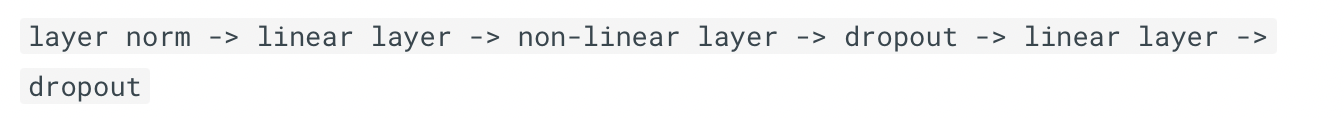

In [5]:
from ViT import MutliLayerPerceptron

mlp = MutliLayerPerceptron(embedding_dim= 768,
                            mlp_size= 3072,
                            dropout= 0.1)

summary(mlp)

Layer (type:depth-idx)                   Param #
MutliLayerPerceptron                     --
├─LayerNorm: 1-1                         1,536
├─Sequential: 1-2                        --
│    └─Linear: 2-1                       2,362,368
│    └─GELU: 2-2                         --
│    └─Dropout: 2-3                      --
│    └─Linear: 2-4                       2,360,064
│    └─Dropout: 2-5                      --
Total params: 4,723,968
Trainable params: 4,723,968
Non-trainable params: 0

# 3.4 Compiling the ViT Network
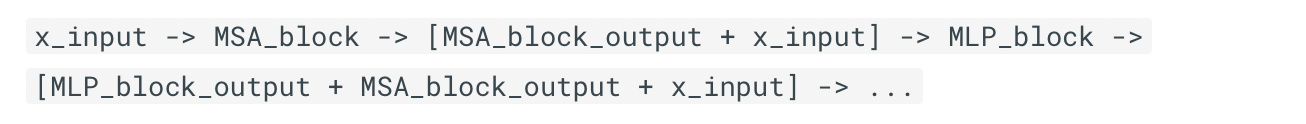

In [2]:
from ViT import TransformerEncoderBlock

vision_transformer = TransformerEncoderBlock(embedding_dim = 768,
                number_of_heads = 12,
                attn_dropout = 0, 
                mlp_size = 3072,
                dropout = 0.1)

summary(vision_transformer)

Layer (type:depth-idx)                                  Param #
TransformerEncoderBlock                                 --
├─MultiheadSeflAttentionBlock: 1-1                      --
│    └─LayerNorm: 2-1                                   1,536
│    └─MultiheadAttention: 2-2                          1,771,776
│    │    └─NonDynamicallyQuantizableLinear: 3-1        590,592
├─MutliLayerPerceptron: 1-2                             --
│    └─LayerNorm: 2-3                                   1,536
│    └─Sequential: 2-4                                  --
│    │    └─Linear: 3-2                                 2,362,368
│    │    └─GELU: 3-3                                   --
│    │    └─Dropout: 3-4                                --
│    │    └─Linear: 3-5                                 2,360,064
│    │    └─Dropout: 3-6                                --
Total params: 7,087,872
Trainable params: 7,087,872
Non-trainable params: 0

|